# Preliminaries

In [1]:
import sys
import pandas as pd
sys.path.append("../PaperNon_Gen_LinCFA/")
from NonLinCFA.NonLinCFA import NonLinCFA
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import r2_score,accuracy_score
import matplotlib.pyplot as plt
from NonLinCFA.NonLinCFA_anyFunction import NonLinCFA_anyFunction
from LinCFA.LinCFA import LinCFA
from GenLinCFA.GenLinCFA import GenLinCFA
from GenLinCFA.GenLinCFA_anyFunction import GenLinCFA_anyFunction
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import random
from DdimensionalExperiment import generate_dataset_n,generate_dataset_quadratic,run_GenLinCFA
from DdimensionalExperiment_quadratic import generate_dataset_squared


In [2]:
def compute_r2(x_train, y_train, x_val, y_val):
    regr = LinearRegression().fit(x_train,y_train)
    y_pred = regr.predict(x_val)
    return r2_score(y_val, y_pred)

In [3]:
def compute_accuracy(x_train, y_train, x_val, y_val):
    regr = LogisticRegression().fit(x_train,y_train)
    y_pred = regr.predict(x_val)
    return accuracy_score(y_val, y_pred)

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def compute_wrapper(x_trainVal, y_trainVal,n_features):
    sfs = SFS(LinearRegression(),
           k_features=n_features,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 5)
    
    sfs.fit(x_trainVal, y_trainVal)
    return pd.DataFrame(sfs.subsets_).transpose()

In [5]:
def squared_aggregation(x):
    x_sq = x**2
    return x_sq.sum(axis=1)

def mean_aggregation(x):
    return x.mean(axis=1)

In [6]:
def linear_experiment_resampling():
    score = []
    list_of_length = []
    wrapper_score = []
    LinCFA_score = []
    list_of_length_lin = []
    GenLinCFA_score = []
    list_of_length_gen = []
    
    for trials in range(10):
        x,y,coeffs = generate_dataset_n(n_data=3000, noise=10, p1=0.3, p2=0.7, n_variables=100, coeffs=[0])
        x = pd.DataFrame(x)
        x['target'] = y
        
        for eps in [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001]:
            output = NonLinCFA_anyFunction(x.iloc[:2000,:],'target', eps, 5 , neigh=0, customFunction=mean_aggregation).compute_clusters()
            print(len(output))
            list_of_length.append(len(output))
            aggregate_x = pd.DataFrame()
            
            for i in range(len(output)):
                aggregate_x[i] = mean_aggregation(x[output[i]])
            
            #print(aggregate_x.head())
            score.append(compute_r2(aggregate_x.iloc[:2000,:], x.loc[:,'target'].iloc[:2000], aggregate_x.iloc[2000:,:], x.loc[:,'target'].iloc[2000:]))
            print(score[-1])
        
        for eps in [0.3,0.35,0.375,0.4,0.4125,0.425,0.45]:
            output = GenLinCFA_anyFunction(x.iloc[:2000,:],'target', eps1=eps, n_val=5 , neigh=0, eps2=1, customFunction=mean_aggregation).compute_clusters()
            print(len(output))
            list_of_length_gen.append(len(output))
            #list_of_length.append(len(output))
            aggregate_x = pd.DataFrame()
        
            for i in range(len(output)):
                aggregate_x[i] = mean_aggregation(x[output[i]])
        
        #print(aggregate_x.head())
            GenLinCFA_score.append(compute_r2(aggregate_x.iloc[:2000,:], x.loc[:,'target'].iloc[:2000], aggregate_x.iloc[2000:,:], x.loc[:,'target'].iloc[2000:]))
            print(GenLinCFA_score[-1])
        
        #for i in range(50):
        res = compute_wrapper(x.iloc[:2000,:-1], x.iloc[:2000,-1], 50)
        for i in range(50):
            x_wrapper_red = x[list(res.loc[i+1,'feature_names'])]
            wrapper_score.append(compute_r2(x_wrapper_red.iloc[:2000],x.loc[:,'target'].iloc[:2000],x_wrapper_red.iloc[2000:],x.loc[:,'target'].iloc[2000:]))
            print(i+1,wrapper_score[-1])
        
        for eps in [0]:
            output = LinCFA(x.iloc[:2000,:],'target', eps, neigh=0).compute_clusters()
            print(len(output))
            list_of_length_lin.append(len(output))
            aggregate_x = pd.DataFrame()
            
            for i in range(len(output)):
                aggregate_x[i] = mean_aggregation(x[output[i]])
            
            #print(aggregate_x.head())
            LinCFA_score.append(compute_r2(aggregate_x.iloc[:2000,:], x.loc[:,'target'].iloc[:2000], aggregate_x.iloc[2000:,:], x.loc[:,'target'].iloc[2000:]))
            print(LinCFA_score[-1])
    return score,list_of_length,wrapper_score,LinCFA_score,list_of_length_lin,GenLinCFA_score,list_of_length_gen
    

In [8]:
def linear_experiment_noResampling(n_reps):
    score = []
    list_of_length = []
    wrapper_score = []
    LinCFA_score = []
    list_of_length_lin = []
    GenLinCFA_score = []
    list_of_length_gen = []
    
    x_all,y_all,coeffs = generate_dataset_n(n_data=3000*10, noise=10, p1=0.3, p2=0.7, n_variables=100, coeffs=[0])
    
    for trials in range(n_reps):
        x = pd.DataFrame(x_all[3000*trials:3000*(trials+1)])
        x['target'] = y_all[3000*trials:3000*(trials+1)]
        
        for eps in [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001]:
            output = NonLinCFA_anyFunction(x.iloc[:2000,:],'target', eps, 5 , neigh=0, customFunction=mean_aggregation).compute_clusters()
            print(len(output))
            list_of_length.append(len(output))
            aggregate_x = pd.DataFrame()
            
            for i in range(len(output)):
                aggregate_x[i] = mean_aggregation(x[output[i]])
            
            #print(aggregate_x.head())
            score.append(compute_r2(aggregate_x.iloc[:2000,:], x.loc[:,'target'].iloc[:2000], aggregate_x.iloc[2000:,:], x.loc[:,'target'].iloc[2000:]))
            print(score[-1])
        
        for eps in [0.3,0.35,0.375,0.4,0.4125,0.425,0.45]:
            output = GenLinCFA_anyFunction(x.iloc[:2000,:],'target', eps1=eps, n_val=5 , neigh=0, eps2=1, customFunction=mean_aggregation).compute_clusters()
            print(len(output))
            list_of_length_gen.append(len(output))
            #list_of_length.append(len(output))
            aggregate_x = pd.DataFrame()
        
            for i in range(len(output)):
                aggregate_x[i] = mean_aggregation(x[output[i]])
        
        #print(aggregate_x.head())
            GenLinCFA_score.append(compute_r2(aggregate_x.iloc[:2000,:], x.loc[:,'target'].iloc[:2000], aggregate_x.iloc[2000:,:], x.loc[:,'target'].iloc[2000:]))
            print(GenLinCFA_score[-1])
        
        #for i in range(50):
        res = compute_wrapper(x.iloc[:2000,:-1], x.iloc[:2000,-1], 50)
        for i in range(50):
            x_wrapper_red = x[list(res.loc[i+1,'feature_names'])]
            wrapper_score.append(compute_r2(x_wrapper_red.iloc[:2000],x.loc[:,'target'].iloc[:2000],x_wrapper_red.iloc[2000:],x.loc[:,'target'].iloc[2000:]))
            print(i+1,wrapper_score[-1])
        
        for eps in [0]:
            output = LinCFA(x.iloc[:2000,:],'target', eps, neigh=0).compute_clusters()
            print(len(output))
            list_of_length_lin.append(len(output))
            aggregate_x = pd.DataFrame()
            
            for i in range(len(output)):
                aggregate_x[i] = mean_aggregation(x[output[i]])
            
            #print(aggregate_x.head())
            LinCFA_score.append(compute_r2(aggregate_x.iloc[:2000,:], x.loc[:,'target'].iloc[:2000], aggregate_x.iloc[2000:,:], x.loc[:,'target'].iloc[2000:]))
            print(LinCFA_score[-1])
    return score,list_of_length,wrapper_score,LinCFA_score,list_of_length_lin,GenLinCFA_score,list_of_length_gen

    

In [7]:
def compute_CI_fromList(lis, list_len, n_reps):
    res = []
    for i in range(list_len):
        res.append([np.mean(lis[i::list_len])-1.96*np.std(lis[i::list_len])/np.sqrt(n_reps),np.mean(lis[i::list_len])+1.96*np.std(lis[i::list_len])/np.sqrt(n_reps)])
    return res

def compute_lower_fromList(lis, list_len, n_reps):
    res = []
    for i in range(list_len):
        res.append(np.mean(lis[i::list_len])-1.96*np.std(lis[i::list_len])/np.sqrt(n_reps))
    return res

def compute_upper_fromList(lis, list_len, n_reps):
    res = []
    for i in range(list_len):
        res.append(np.mean(lis[i::list_len])+1.96*np.std(lis[i::list_len])/np.sqrt(n_reps))
    return res

def compute_means_fromList(lis, list_len):
    res = []
    for i in range(list_len):
        res.append(np.mean(lis[i::list_len]))
    return res


# Linear dependence, input=feature, mean as aggregation, first trial

In [10]:
lin_score,lin_list_of_length,lin_wrapper_score,lin_LinCFA_score,lin_list_of_length_lin,lin_GenLinCFA_score,lin_list_of_length_gen = linear_experiment_resampling()


1
0.8817966330061661
1
0.8817966330061661
5
0.8820215451678672
21
0.8836656019498874
25
0.882466462744487
23
0.8825802084847787
22
0.8835012309635005
40
0.8807109875791379
25
0.8811377170596879
15
0.8824218989043883
10
0.8825791759538643
6
0.8819844243286494
4
0.8820360033544787
1
0.8817966330061661
1 0.7538899708223442
2 0.7807372947467764
3 0.8018624376795207
4 0.8121997255736462
5 0.8223522064402358
6 0.8301376030616282
7 0.836971620504213
8 0.8472091752798463
9 0.8487582407976074
10 0.8485366254834882
11 0.8520882837685617
12 0.85485028438627
13 0.8569162541182482
14 0.8590486947342697
15 0.8610609071227546
16 0.8625731877364119
17 0.8621368680842687
18 0.8634178501331029
19 0.861534561980402
20 0.8634617790187009
21 0.8661574248553321
22 0.8670858214956714
23 0.8668547257571438
24 0.8671502564259118
25 0.8683785669960351
26 0.8694981631041512
27 0.8693846160024189
28 0.8703976206949713
29 0.8703485650157752
30 0.8718388857601755
31 0.8727298950072098
32 0.8724391010744208
33 0.872

40
0.9089741011878893
1
0.876230303021237
1
0.876230303021237
11
0.8770713485273053
11
0.8775482674469037
20
0.8778254582073721
18
0.8764752004275123
18
0.8764752004275123
22
0.877134955856377
11
0.8767120352684915
6
0.8781055298502877
3
0.8765147580978842
2
0.8761844473362717
1
0.876230303021237
1
0.876230303021237
1 0.6292582595571139
2 0.7335451247070128
3 0.7764866956946761
4 0.784934714763992
5 0.8025035663256861
6 0.8117842328060121
7 0.8258976251085055
8 0.8311161183027505
9 0.8383827927195169
10 0.8409541748829819
11 0.8462093783257971
12 0.8490644874716065
13 0.8510061389040199
14 0.8517118471563297
15 0.8534829683854734
16 0.852941216105561
17 0.8535328871544329
18 0.853582097217466
19 0.854746934701174
20 0.8561741097099385
21 0.8567599988699144
22 0.8577781894684234
23 0.8589939886378106
24 0.8587978379164836
25 0.8596432151302809
26 0.8612018151026146
27 0.8623009214842121
28 0.8643004665430194
29 0.8648707620615598
30 0.8649829836227607
31 0.8659965494869908
32 0.86680018

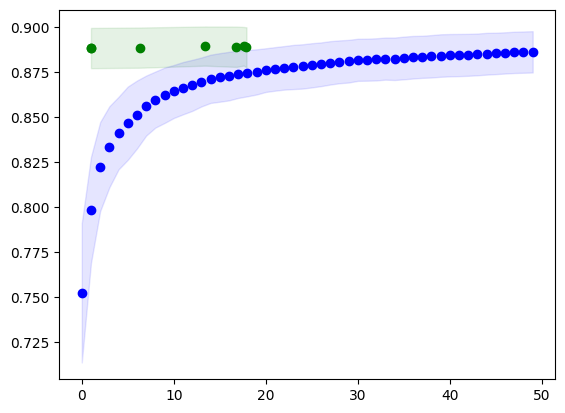

In [41]:
cm = compute_means_fromList(lin_list_of_length, 7)
rm = compute_means_fromList(lin_score, 7)
us = compute_upper_fromList(lin_score, 7, 10)
ls = compute_lower_fromList(lin_score, 7, 10)
cm_sorted = [x for x,_ in sorted(zip(cm,ls))]
rm_sorted = [x for _,x in sorted(zip(cm,rm))]
ls_sorted = [x for _,x in sorted(zip(cm,ls))]
us_sorted = [x for _,x in sorted(zip(cm,us))]

fig, ax = plt.subplots()
ax.plot(cm_sorted,rm_sorted,'go')
ax.fill_between(cm_sorted, (ls_sorted), (us_sorted), color='g', alpha=.1)
ax.plot(compute_means_fromList(lin_wrapper_score,50),'bo')
ax.fill_between(range(50), compute_lower_fromList(lin_wrapper_score,50,10), compute_upper_fromList(lin_wrapper_score,50,10), color='b', alpha=.1)


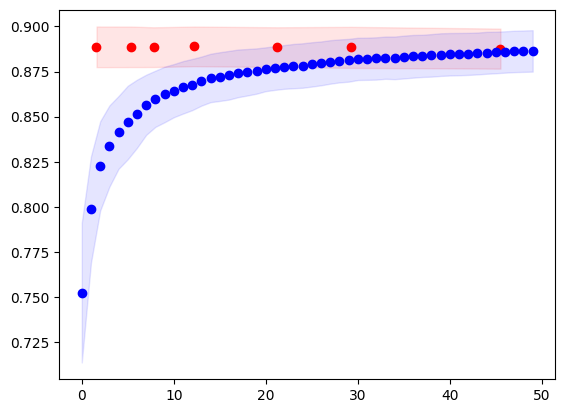

In [52]:
cm = compute_means_fromList(lin_list_of_length_gen, 7)
rm = compute_means_fromList(lin_GenLinCFA_score, 7)
us = compute_upper_fromList(lin_GenLinCFA_score, 7, 10)
ls = compute_lower_fromList(lin_GenLinCFA_score, 7, 10)
fig, ax = plt.subplots()
ax.plot(cm,rm,'ro')
ax.fill_between(cm, (ls), (us), color='r', alpha=.1)
ax.plot(compute_means_fromList(lin_wrapper_score,50),'bo')
ax.fill_between(range(50), compute_lower_fromList(lin_wrapper_score,50,10), compute_upper_fromList(lin_wrapper_score,50,10), color='b', alpha=.1)


In [59]:
print(f'LinCFA result: {np.mean(lin_LinCFA_score)} with {lin_list_of_length_lin} reduced features')

LinCFA result: 0.8891591909939184 with [38, 38, 41, 33, 44, 40, 37, 36, 38, 38] reduced features


# Repeat using the same distribution

In [55]:
lin2_score,lin2_list_of_length,lin2_wrapper_score,lin2_LinCFA_score,lin2_list_of_length_lin,lin2_GenLinCFA_score,lin2_list_of_length_gen = linear_experiment_noResampling(10)


1
0.8880956759252863
1
0.8880956759252863
2
0.8883636842956287
11
0.8921795104881671
13
0.8929325614443642
14
0.8926536236100118
15
0.8932155940780715
57
0.8945298150352698
41
0.892796287438592
28
0.8932199045259764
19
0.891463226302124
14
0.8913310458676756
11
0.8906953720331078
2
0.888420954434259
1 0.8183609180275146
2 0.8406006672475028
3 0.8587618988617504
4 0.8651077572239831
5 0.8680982083869794
6 0.8710996548941699
7 0.8732285845884031
8 0.8757022596306532
9 0.8778071503922912
10 0.8787127785908995
11 0.8783013112919728
12 0.8812084705343686
13 0.883078859254669
14 0.8844506202768785
15 0.884610966781385
16 0.8853251015698956
17 0.8854361968615337
18 0.8863670818589968
19 0.885732405909858
20 0.8862272553701469
21 0.8877269648899154
22 0.8890303329748063
23 0.889667895478342
24 0.8896055728722891
25 0.8892971702804069
26 0.8891251164029019
27 0.8884810000980452
28 0.8887253273410548
29 0.8889184021212417
30 0.8895168343543748
31 0.8894942273757707
32 0.8903461606330211
33 0.890

39
0.9017470877428849
1
0.8826529317422573
1
0.8826529317422573
3
0.8825081561003176
13
0.8838196794077815
15
0.8834992261915244
15
0.8834992261915244
15
0.8834992261915244
56
0.885539871511144
42
0.8849307877306168
28
0.8847713697834391
18
0.8847247472766904
13
0.884662692913912
10
0.8842683227293496
2
0.882788368161381
1 0.7946660939535615
2 0.8254118700459598
3 0.8442886962006421
4 0.8474250106827179
5 0.8516559572571335
6 0.8557109611094559
7 0.8615730235864182
8 0.8620553429475759
9 0.8631658019490236
10 0.8655571301599612
11 0.8673859118046101
12 0.8686712168291028
13 0.8707313232130925
14 0.8712862408209432
15 0.871599400280154
16 0.8735046773888206
17 0.8750457760726187
18 0.8752359543183474
19 0.8738213380519582
20 0.875215240700723
21 0.8765175627333275
22 0.8767979808580965
23 0.8763920636304696
24 0.8766240395668373
25 0.8762049627553947
26 0.8763924050319308
27 0.8769070631433783
28 0.8773012341602064
29 0.8776109716868699
30 0.8774443013987856
31 0.8781517787356776
32 0.8

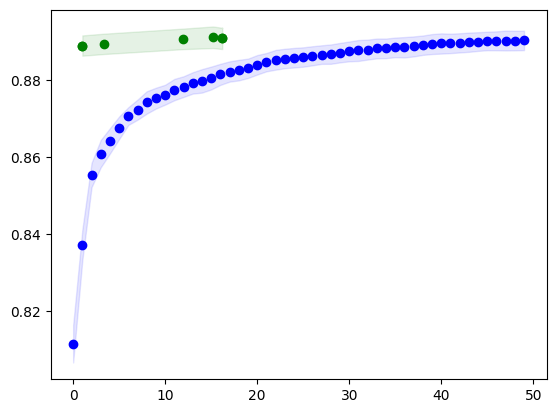

In [56]:
cm = compute_means_fromList(lin2_list_of_length, 7)
rm = compute_means_fromList(lin2_score, 7)
us = compute_upper_fromList(lin2_score, 7, 10)
ls = compute_lower_fromList(lin2_score, 7, 10)
cm_sorted = [x for x,_ in sorted(zip(cm,ls))]
rm_sorted = [x for _,x in sorted(zip(cm,rm))]
ls_sorted = [x for _,x in sorted(zip(cm,ls))]
us_sorted = [x for _,x in sorted(zip(cm,us))]

fig, ax = plt.subplots()
ax.plot(cm_sorted,rm_sorted,'go')
ax.fill_between(cm_sorted, (ls_sorted), (us_sorted), color='g', alpha=.1)
ax.plot(compute_means_fromList(lin2_wrapper_score,50),'bo')
ax.fill_between(range(50), compute_lower_fromList(lin2_wrapper_score,50,10), compute_upper_fromList(lin2_wrapper_score,50,10), color='b', alpha=.1)


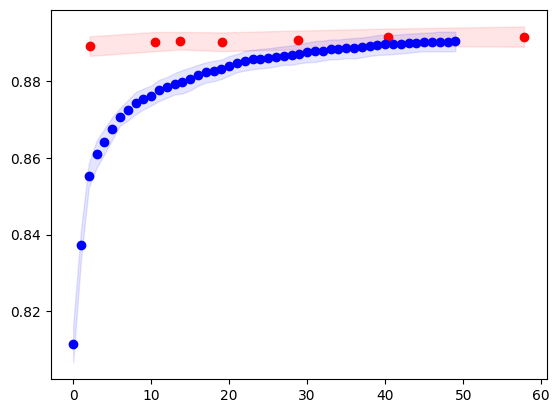

In [57]:
cm = compute_means_fromList(lin2_list_of_length_gen, 7)
rm = compute_means_fromList(lin2_GenLinCFA_score, 7)
us = compute_upper_fromList(lin2_GenLinCFA_score, 7, 10)
ls = compute_lower_fromList(lin2_GenLinCFA_score, 7, 10)
fig, ax = plt.subplots()
ax.plot(cm,rm,'ro')
ax.fill_between(cm, (ls), (us), color='r', alpha=.1)
ax.plot(compute_means_fromList(lin2_wrapper_score,50),'bo')
ax.fill_between(range(50), compute_lower_fromList(lin2_wrapper_score,50,10), compute_upper_fromList(lin2_wrapper_score,50,10), color='b', alpha=.1)


In [60]:
print(f'LinCFA result: {np.mean(lin2_LinCFA_score)} with {lin2_list_of_length_lin} reduced features')

LinCFA result: 0.8912873291315359 with [38, 38, 38, 44, 40, 39, 39, 36, 41, 39] reduced features


# Structured experiment, linear: run script, save result, plot here from script

### plot function

In [9]:
import math
def plot_linear_result(res,title,wrapper_stop,savename,res2):
    # in 0 ho NonLinCFA, in 1 wrapper

    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(7):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results[0][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std]
    print(f'NonLinCFA:\n number of red features:{count_means[1:-1]} +- {count_plusminus[1:-1]},\n R2 score: {R2_means[1:-1]} +- {R2_means_plusminus[1:-1]}\n')

    fig, ax = plt.subplots()
    ax.set_xlabel("Number of reduced features")
    ax.set_ylabel("R2 score")
    ax.plot([round(x) for x in count_means[1:-1]],R2_means[1:-1],'go',label='NonLinCFA score')
    ax.fill_between([round(x) for x in count_means[1:-1]], ([i-j for i,j in zip(R2_means[1:-1], R2_means_plusminus[1:-1])]), ([i+j for i,j in zip(R2_means[1:-1], R2_means_plusminus[1:-1])]), color='g', alpha=.1)
    
    wrapper_means = []
    wrapper_std = []
    
    for i in range(50):
        wrapper_means.append(np.mean(results[1][i::50]))
        wrapper_std.append(np.std(results[1][i::50]))
    wrapper_plusminus = [x*1.96/np.sqrt(10) for x in wrapper_std]
    
    print(f'Wrapper:\n Mean values {wrapper_means} +- {wrapper_plusminus}\n')
    ax.plot(range(1,wrapper_stop),wrapper_means[:(wrapper_stop-1)],'bo',label='Wrapper score')
    ax.fill_between(range(1,wrapper_stop), ([i-j for i,j in zip(wrapper_means[:(wrapper_stop-1)], wrapper_plusminus[:(wrapper_stop-1)])]), ([i+j for i,j in zip(wrapper_means[:(wrapper_stop-1)], wrapper_plusminus[:(wrapper_stop-1)])]), color='b', alpha=.1)
    
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(5):
        dummy_list = []
        for i in range(10):
            dummy_list.append(res2[0][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std]

    print(f'GenLinCFA:\n number of red features:{count_means} +- {count_plusminus},\n R2 score: {R2_means} +- {R2_means_plusminus}\n')
    
    ax.plot([round(x) for x in count_means],R2_means,'rs',label='GenLinCFA score',fillstyle='none')
    ax.fill_between([round(x) for x in count_means], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='r', alpha=.1)
    
    print(f'LinCFA:\n mean {np.mean(results[2])}, confidence interval [{np.mean(results[2])-1.96*np.std(results[2])/np.sqrt(10)},{np.mean(results[2])+1.96*np.std(results[2])/np.sqrt(10)}],')
    print(f'with number of reduced features: {np.mean(results[3])}, confidence interval [{np.mean(results[3])-1.96*np.std(results[3])/np.sqrt(10)},{np.mean(results[3])+1.96*np.std(results[3])/np.sqrt(10)}]')
    
    plt.title(title)
    plt.legend()
    
    plt.savefig(savename, format='png', dpi=1200)
    plt.show()
    

### Low noise, 100 variables, linear dependence

In [12]:
import pickle
with open('results/linear_lowNoise_100var.pkl', 'rb') as f:
    results = pickle.load(f)

with open('results/linear_lowNoise_100var_onlyGen.pkl', 'rb') as f:
    results2 = pickle.load(f)

In [13]:
print(f'NonLinCFA epsilon: {[results[0][0][i][0] for i in range(7)]}')
print(f'GenLinCFA epsilon: {[results2[0][0][i][0] for i in range(5)]}')

NonLinCFA epsilon: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
GenLinCFA epsilon: [0.76, 0.77, 0.78, 0.79, 0.8]


NonLinCFA:
 number of red features:[1.0, 8.0, 11.4, 14.4, 14.7] +- [0.0, 0.8765386471799175, 1.4456245709035245, 1.276259534734217, 1.2098138699816594],
 R2 score: [0.8655215785894974, 0.8663963367073707, 0.8660527311262882, 0.8658764264928565, 0.8663889970491097] +- [0.005065200704867381, 0.004751893342010827, 0.004874233714607369, 0.005024884367078448, 0.00433416556615672]

Wrapper:
 Mean values [0.7618800883682314, 0.7925098529490984, 0.8078723723579652, 0.8205446073009851, 0.8280159426628593, 0.8344789502588549, 0.839275234057725, 0.8423316960004839, 0.8450262859322881, 0.846936063320413, 0.8485963098734693, 0.8493849164649946, 0.8505980355515804, 0.8516217530522064, 0.8522112865194309, 0.8533402455408263, 0.8544591147489904, 0.8550426722766467, 0.8559530916633713, 0.8567911573105098, 0.8572701588739269, 0.857522040149471, 0.8580024068871177, 0.8584481586103827, 0.8589109744821428, 0.859463111885964, 0.8600552311120204, 0.8602174018174683, 0.8604303642636342, 0.860654511035789, 0.8

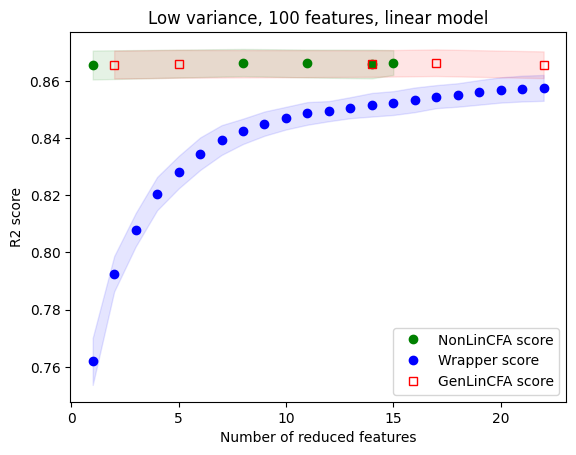

In [14]:
plot_linear_result(results,'Low variance, 100 features, linear model',23,'LowVar_100Feat_lin.png',results2)

In [20]:
0.8708795735888172-0.8659457480503938

0.004933825538423364

### High noise, 1000 variables, linear dependence

In [15]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/Linear_HighNoise_1000var.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/Linear_HighNoise_1000var_OnlyGen.pkl', 'rb') as f:
    results2 = pickle.load(f)

In [16]:
print(f'NonLinCFA epsilon: {[results[0][0][i][0] for i in range(7)]}')
print(f'GenLinCFA epsilon: {[results2[0][0][i][0] for i in range(5)]}')

NonLinCFA epsilon: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
GenLinCFA epsilon: [0.76, 0.77, 0.78, 0.79, 0.8]


NonLinCFA:
 number of red features:[1.0, 3.1, 18.0, 21.9, 22.3] +- [0.0, 0.6470969015533917, 1.9203999583420115, 2.1009517843111007, 1.901301028243555],
 R2 score: [0.7331785859981281, 0.7318399096256514, 0.7273622438417259, 0.7264645636402756, 0.7267467306766292] +- [0.006919557090134497, 0.007097774274391802, 0.007900826451524923, 0.0072330984949896685, 0.00756874782221514]

Wrapper:
 Mean values [0.6459180200226504, 0.6645209752516574, 0.6786353707203743, 0.6847866260321733, 0.6875357649150693, 0.6901587001803189, 0.6917246227991605, 0.6933028523696785, 0.6937751671759953, 0.6933643294721039, 0.6946437425962897, 0.6950026384006219, 0.6956886629049504, 0.6967577013154108, 0.6978174877271465, 0.6970549203477496, 0.6975132397612498, 0.6974245666079647, 0.6977761794010575, 0.6977246056912791, 0.6985350772862586, 0.6981120241123071, 0.6980480380510614, 0.6983439293965918, 0.69823144204184, 0.6986214652365897, 0.698558348147529, 0.6987993427553463, 0.6994468222397401, 0.6991977427113227, 

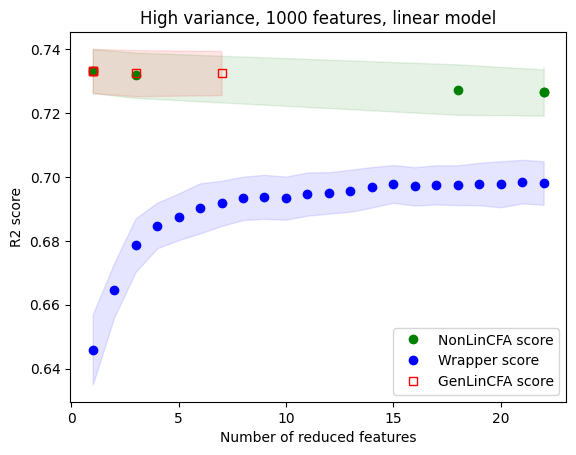

In [17]:
plot_linear_result(results, 'High variance, 1000 features, linear model',23, 'HighVar_1000Feat_lin.png',results2)

# Quadratic relationship, plot

### plot function

In [18]:
# in 0 NonLinCFA, in 1 wrapper
def plot_quadratic(results,title,savename,results2,wrapper_stop):
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(7):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results[0][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std]
    
    print(f'NonLinCFA:\n number of red features:{count_means[1:-1]} +- {count_plusminus[1:-1]},\n R2 score: {R2_means[1:-1]} +- {R2_means_plusminus[1:-1]}\n')
    
    count_means_sorted = [x for x in sorted(count_means[1:-1])]
    R2_means = [x for _,x in sorted(zip(count_means[1:-1],R2_means[1:-1]))]
    R2_means_plusminus = [x for _,x in sorted(zip(count_means[1:-1],R2_means_plusminus[1:-1]))]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of reduced features")
    ax.set_ylabel("R2 score")
    ax.plot([round(x) for x in count_means_sorted],R2_means,'go',label='NonLinCFA score')
    ax.fill_between([round(x) for x in count_means_sorted], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='g', alpha=.1)
    
    wrapper_means = []
    wrapper_std = []
    
    for i in range(50):
        wrapper_means.append(np.mean(results[1][i::50]))
        wrapper_std.append(np.std(results[1][i::50]))
    wrapper_plusminus = [x*1.96/np.sqrt(10) for x in wrapper_std]
    print(f'Wrapper:\n Mean values {wrapper_means} +- {wrapper_plusminus}\n')

    ax.plot(range(1,wrapper_stop+1),wrapper_means[:wrapper_stop],'bo',label='Wrapper score')
    ax.fill_between(range(1,wrapper_stop+1), ([i-j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), ([i+j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), color='b', alpha=.1)
    
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(5):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results2[0][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    
    print(f'GenLinCFA:\n number of red features:{count_means} +- {count_plusminus},\n R2 score: {R2_means} +- {R2_means_plusminus}\n')

    
    ax.plot([round(x) for x in count_means],R2_means,'rs',label='GenLinCFA score',fillstyle='none')
    ax.fill_between([round(x) for x in count_means], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='r', alpha=.1)
    
    print(f'SQUARED FEATURES:\nLinCFA mean {np.mean(results[2])}, confidence interval [{np.mean(results[2])-1.96*np.std(results[2])/np.sqrt(10)},{np.mean(results[2])+1.96*np.std(results[2])/np.sqrt(10)}],')
    print(f'with number of reduced features: {np.mean(results[3])}, confidence interval [{np.mean(results[3])-1.96*np.std(results[3])/np.sqrt(10)},{np.mean(results[3])+1.96*np.std(results[3])/np.sqrt(10)}]')

    plt.title(title)
    plt.legend()
    
    plt.savefig(savename, format='png', dpi=1200)
    
    plt.show()


### Low noise, 100 variables, quadratic dependence

In [19]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_lowNoise_100var.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_lowNoise_100var_onlyGen.pkl', 'rb') as f:
    results2 = pickle.load(f)
    

In [20]:
print(f'NonLinCFA epsilon: {[results[0][0][i][0] for i in range(7)]}')
print(f'GenLinCFA epsilon: {[results2[0][0][i][0] for i in range(5)]}')


NonLinCFA epsilon: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
GenLinCFA epsilon: [0.68, 0.7, 0.72, 0.74, 0.76]


NonLinCFA:
 number of red features:[1.0, 7.1, 10.3, 12.9, 12.4] +- [0.0, 0.852092952675939, 1.6410245580124632, 1.5789865103920298, 1.3914619649850297],
 R2 score: [0.7435796504110674, 0.7469435190462297, 0.7483113277255279, 0.7478827217848412, 0.7475181023920491] +- [0.009613153691609828, 0.009719453041330275, 0.009980777648615158, 0.009921865757770227, 0.009696986760829673]

Wrapper:
 Mean values [0.4588728244122411, 0.5223470777812327, 0.5646268658280296, 0.5911582610061302, 0.6139461193772527, 0.633126609370802, 0.651206783516486, 0.6609334203086007, 0.6694324178672105, 0.674824077892848, 0.6810727971064592, 0.6865674037826511, 0.6908673425311546, 0.6960644836032694, 0.6994004249102292, 0.7019649158242594, 0.7049070110434679, 0.7077232182124751, 0.7117070206655665, 0.7146729578041104, 0.7165480358673113, 0.7180030302107419, 0.719319041540922, 0.7216983702263332, 0.7232596652903627, 0.7247329222494996, 0.7263887028401307, 0.7285888979030128, 0.7300831310567156, 0.7312239192768402, 0

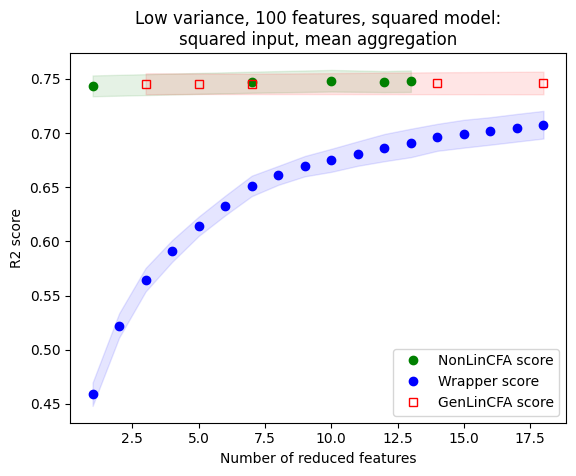

In [21]:
plot_quadratic(results,"Low variance, 100 features, squared model:\nsquared input, mean aggregation",'LowVar_100Feat_quadr.png',results2,18)


### High noise, 1000 variables, quadratic dependence

In [22]:
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_highNoise_1000var.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_highNoise_1000var_onlyGen.pkl', 'rb') as f:
    results2 = pickle.load(f)
    

In [23]:
print(f'NonLinCFA epsilon: {[results[0][0][i][0] for i in range(7)]}')
print(f'GenLinCFA epsilon: {[results2[0][0][i][0] for i in range(5)]}')


NonLinCFA epsilon: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
GenLinCFA epsilon: [0.68, 0.7, 0.72, 0.74, 0.76]


NonLinCFA:
 number of red features:[1.0, 5.9, 11.6, 13.2, 13.7] +- [0.0, 0.7565701553722562, 0.690187220977033, 0.6072837886853228, 0.6228977444171715],
 R2 score: [0.4043600294140658, 0.3873536998825163, 0.3735210038242839, 0.36277098329044266, 0.36496033201194733] +- [0.013070969124468677, 0.01841887174306367, 0.017922417169732162, 0.020044624454245933, 0.019976669055864083]

Wrapper:
 Mean values [0.24682387520675286, 0.2663863841926727, 0.28242638483621507, 0.2908549685697016, 0.29951079060876334, 0.3043620111862685, 0.30657915144761166, 0.30732995095040727, 0.3062713287400328, 0.305364729531867, 0.3060518187972073, 0.30698081837724756, 0.3074702817241948, 0.3062614512088471, 0.3070664881062214, 0.3062544994565551, 0.3060496585868935, 0.30713468799494825, 0.3050265647413321, 0.30536591168334504, 0.305025483413231, 0.30446346787810435, 0.30419846986843363, 0.30513943790726933, 0.30545914797713025, 0.30554195124994404, 0.30612798137442143, 0.3057718599119472, 0.3058740575979249, 0.30

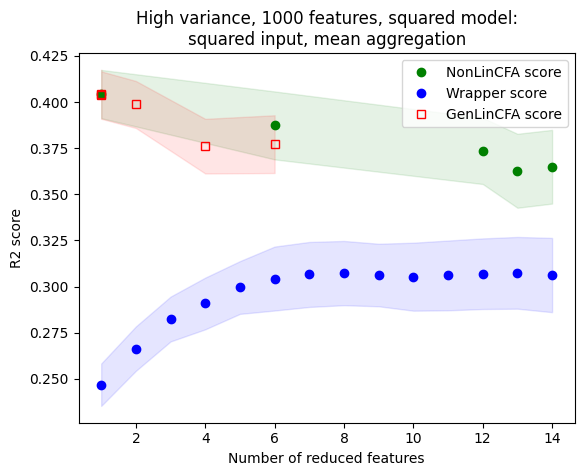

In [24]:
plot_quadratic(results,"High variance, 1000 features, squared model:\nsquared input, mean aggregation",'HIghVar_1000Feat_quadr.png',results2,14)


## Repeat considering linear input and squared sums to aggregate

### plot function

In [26]:
def plot_squaredAggr(results,title,savename,results2,wrapper_stop):
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(7):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results[5][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std[1:-1]]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std[1:-1]]
    
    print(f'NonLinCFA:\n number of red features:{count_means[1:-1]} +- {count_plusminus},\n R2 score: {R2_means[1:-1]} +- {R2_means_plusminus}\n')
    
    count_means_sorted = [x for x in sorted(count_means[1:-1])]
    R2_means = [x for _,x in sorted(zip(count_means[1:-1],R2_means[1:-1]))]
    R2_means_plusminus = [x for _,x in sorted(zip(count_means[1:-1],R2_means_plusminus))]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of reduced features")
    ax.set_ylabel("R2 score")
    ax.plot([round(x) for x in count_means_sorted],R2_means,'go',label='NonLinCFA score')
    ax.fill_between([round(x) for x in count_means_sorted], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='g', alpha=.1)
    
    wrapper_means = []
    wrapper_std = []
    
    for i in range(50):
        wrapper_means.append(np.mean(results[1][i::50]))
        wrapper_std.append(np.std(results[1][i::50]))
    wrapper_plusminus = [x*1.96/np.sqrt(10) for x in wrapper_std]
    print(f'Wrapper:\n Mean values {wrapper_means} +- {wrapper_plusminus}\n')

    ax.plot(range(1,wrapper_stop+1),wrapper_means[:wrapper_stop],'bo',label='Wrapper score')
    ax.fill_between(range(1,wrapper_stop+1), ([i-j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), ([i+j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), color='b', alpha=.1)
    
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(5):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results2[1][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    
    print(f'GenLinCFA:\n number of red features:{count_means} +- {count_plusminus},\n R2 score: {R2_means} +- {R2_means_plusminus}\n')

    ax.plot([round(x) for x in count_means],R2_means,'rs',label='GenLinCFA score',fillstyle='none')
    ax.fill_between([round(x) for x in count_means], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='r', alpha=.1)

    plt.title(title)
    plt.legend()
    plt.savefig(savename, format='png', dpi=1200)
    
    
    plt.show()


### Low noise, 100 variables, quadratic dependence

In [27]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_lowNoise_100var.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_lowNoise_100var_onlyGen.pkl', 'rb') as f:
    results2 = pickle.load(f)
    

In [28]:
print(f'NonLinCFA epsilon: {[results[5][0][i][0] for i in range(7)]}')
print(f'GenLinCFA epsilon: {[results2[1][0][i][0] for i in range(5)]}')


NonLinCFA epsilon: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
GenLinCFA epsilon: [0.68, 0.7, 0.72, 0.74, 0.76]


NonLinCFA:
 number of red features:[1.0, 2.8, 3.8, 4.1, 4.1] +- [0.0, 0.4638206549950098, 0.3718838528358014, 0.43386449497510166, 0.43386449497510166],
 R2 score: [0.7435796504110674, 0.7455923801513561, 0.7514748171087419, 0.7529332012932627, 0.7539048076870722] +- [0.009613153691609823, 0.009332800682799089, 0.009579663806688241, 0.009468732130713182, 0.009728952173565836]

Wrapper:
 Mean values [0.4588728244122411, 0.5223470777812327, 0.5646268658280296, 0.5911582610061302, 0.6139461193772527, 0.633126609370802, 0.651206783516486, 0.6609334203086007, 0.6694324178672105, 0.674824077892848, 0.6810727971064592, 0.6865674037826511, 0.6908673425311546, 0.6960644836032694, 0.6994004249102292, 0.7019649158242594, 0.7049070110434679, 0.7077232182124751, 0.7117070206655665, 0.7146729578041104, 0.7165480358673113, 0.7180030302107419, 0.719319041540922, 0.7216983702263332, 0.7232596652903627, 0.7247329222494996, 0.7263887028401307, 0.7285888979030128, 0.7300831310567156, 0.7312239192768402, 0

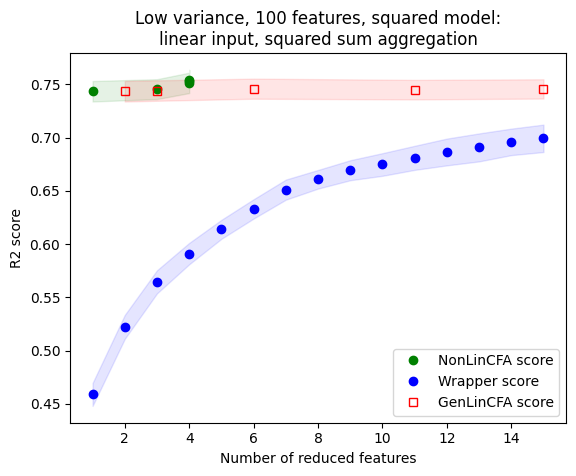

In [29]:
plot_squaredAggr(results,"Low variance, 100 features, squared model:\nlinear input, squared sum aggregation",'LowVar_100Feat_squaredAggr.png',results2,15)


### High noise, 1000 variables, quadratic dependence

In [30]:
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_highNoise_1000var.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/squared_highNoise_1000var_onlyGen.pkl', 'rb') as f:
    results2 = pickle.load(f)

print(f'NonLinCFA epsilon: {[results[5][0][i][0] for i in range(7)]}')
print(f'GenLinCFA epsilon: {[results2[1][0][i][0] for i in range(5)]}')

NonLinCFA epsilon: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
GenLinCFA epsilon: [0.68, 0.7, 0.72, 0.74, 0.76]


NonLinCFA:
 number of red features:[1.0, 6.3, 15.5, 17.7, 18.0] +- [0.0, 0.7864461837913641, 1.5495160534825059, 1.9213999063183071, 1.8386429778507842],
 R2 score: [0.4043600294140659, 0.40066945402735515, 0.3843090728533701, 0.3785464497064927, 0.3772973315928946] +- [0.013070969124468663, 0.013480973372648168, 0.014034228333703535, 0.015643215713622927, 0.01662247144619444]

Wrapper:
 Mean values [0.24682387520675286, 0.2663863841926727, 0.28242638483621507, 0.2908549685697016, 0.29951079060876334, 0.3043620111862685, 0.30657915144761166, 0.30732995095040727, 0.3062713287400328, 0.305364729531867, 0.3060518187972073, 0.30698081837724756, 0.3074702817241948, 0.3062614512088471, 0.3070664881062214, 0.3062544994565551, 0.3060496585868935, 0.30713468799494825, 0.3050265647413321, 0.30536591168334504, 0.305025483413231, 0.30446346787810435, 0.30419846986843363, 0.30513943790726933, 0.30545914797713025, 0.30554195124994404, 0.30612798137442143, 0.3057718599119472, 0.3058740575979249, 0.30

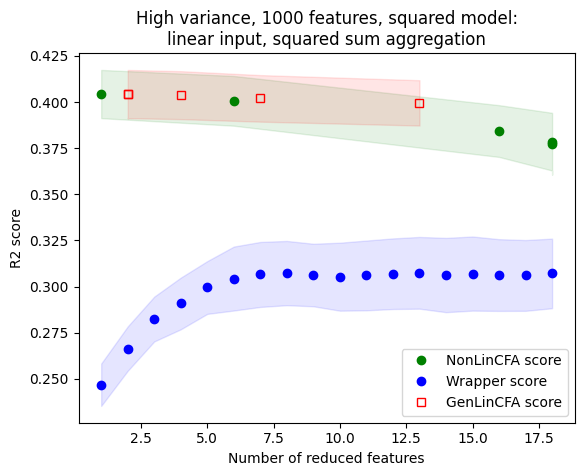

In [31]:
plot_squaredAggr(results,"High variance, 1000 features, squared model:\nlinear input, squared sum aggregation",'HighVar_1000Feat_squaredAggr.png',results2,18)


# classification

### plot function

In [32]:
# in 0 ho wrapper, in 1 GenLinCFA
def plot_class(result,title,wrapper_stop,savename):
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of reduced features")
    ax.set_ylabel("Accuracy score")
    
    wrapper_means = []
    wrapper_std = []
    
    for i in range(50):
        wrapper_means.append(np.mean(results[0][i::50]))
        wrapper_std.append(np.std(results[0][i::50]))
    wrapper_plusminus = [x*1.96/np.sqrt(10) for x in wrapper_std]
    
    print(f'Wrapper:\n Mean values {wrapper_means} +- {wrapper_plusminus}\n')

    ax.plot(range(1,(wrapper_stop+1)),wrapper_means[:wrapper_stop],'bo',label='Wrapper score')
    ax.fill_between(range(1,(wrapper_stop+1)), ([i-j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), ([i+j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), color='b', alpha=.1)
    
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(5):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results[1][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std]

    print(f'GenLinCFA:\n number of red features:{count_means} +- {count_plusminus},\n R2 score: {R2_means} +- {R2_means_plusminus}\n')

    ax.plot([round(x) for x in count_means],R2_means,'rs',label='GenLinCFA score',fillstyle='none')
    ax.fill_between([round(x) for x in count_means], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='r', alpha=.1)
    
    plt.title(title)
    plt.legend()
    plt.savefig(savename, format='png', dpi=1200)

    plt.show()

### Low noise, 100 variables, linear dependence, class

In [33]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/class_retry.pkl', 'rb') as f:
    results = pickle.load(f)
    

In [34]:
print(f'GenLinCFA epsilon: {[results[1][0][i][0] for i in range(5)]}')


GenLinCFA epsilon: [0.71, 0.72, 0.73, 0.75, 0.77]


Wrapper:
 Mean values [0.866, 0.8708, 0.8769, 0.8774, 0.8769, 0.8775000000000001, 0.8786000000000002, 0.8794000000000001, 0.8815000000000002, 0.8814, 0.8833, 0.8831, 0.883, 0.884, 0.8840999999999999, 0.8842000000000001, 0.8841000000000001, 0.8850999999999999, 0.8851000000000001, 0.8851000000000001, 0.8836, 0.8844999999999998, 0.8835000000000001, 0.8834, 0.8833, 0.8834, 0.8840000000000001, 0.8840999999999999, 0.8847000000000002, 0.8833, 0.8829, 0.8834, 0.8831999999999999, 0.8834, 0.8836999999999999, 0.884, 0.8849, 0.8847000000000002, 0.8857000000000002, 0.8863, 0.8854, 0.8852, 0.8853, 0.8867, 0.8862, 0.8871, 0.8865000000000001, 0.8868, 0.8867, 0.8872] +- [0.007083169911840325, 0.005859056033184873, 0.007429666910434148, 0.006224041645104896, 0.006746785782874693, 0.005762866647771753, 0.006607264365832509, 0.005978481947785747, 0.005769528923577735, 0.0057089521280178955, 0.006429576782339572, 0.006176021891152918, 0.006646683383462767, 0.006278122012194416, 0.007074758398701688, 0.0070

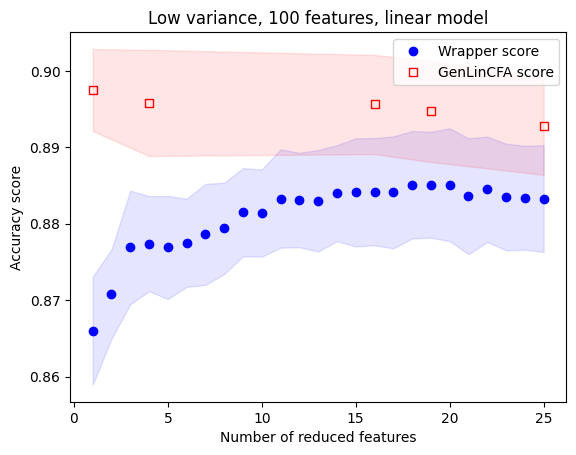

In [35]:
plot_class(results,"Low variance, 100 features, linear model",25,'LowVar_100Feat_lin_class.png')


### High noise, 100 variables, linear dependence, class


In [36]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/class_retry_highNoise.pkl', 'rb') as f:
    results = pickle.load(f)
    

In [37]:
print(f'GenLinCFA epsilon: {[results[1][0][i][0] for i in range(5)]}')


GenLinCFA epsilon: [0.71, 0.72, 0.73, 0.75, 0.77]


Wrapper:
 Mean values [0.8271, 0.829, 0.8310000000000001, 0.8310000000000001, 0.8318, 0.8339000000000001, 0.8335999999999999, 0.8343, 0.8344999999999999, 0.8343, 0.835, 0.8343, 0.8347, 0.8345, 0.834, 0.8335999999999999, 0.8337, 0.834, 0.834, 0.8337, 0.834, 0.8335999999999999, 0.8333999999999999, 0.8332, 0.8329000000000001, 0.8334999999999999, 0.8337999999999999, 0.8335999999999999, 0.8346, 0.8344999999999999, 0.8346, 0.8342, 0.8341, 0.8338999999999999, 0.8337999999999999, 0.8339000000000001, 0.8334999999999999, 0.8338000000000001, 0.8336, 0.8332, 0.8327, 0.8333, 0.8333999999999999, 0.8337999999999999, 0.8338999999999999, 0.8335000000000001, 0.8337999999999999, 0.8346, 0.8352, 0.8347] +- [0.007377779503346514, 0.008434834438209193, 0.00848931186846141, 0.008743445545092616, 0.008188954121253816, 0.007915342974249432, 0.008181444762387623, 0.008114731394199062, 0.008191064888035003, 0.0080290653005191, 0.008264602107784732, 0.007859819947047124, 0.007499657698855318, 0.007469888888062517

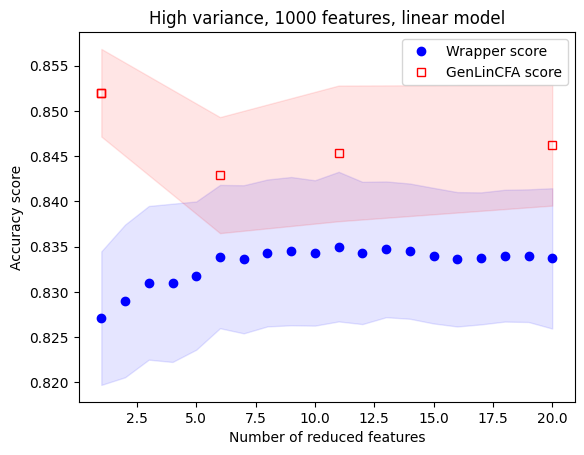

In [38]:
plot_class(results,"High variance, 1000 features, linear model",20,'HighVar_1000Feat_lin_class.png')


# Quadratic

### plot function

In [39]:
# in 0 ho wrapper, in 1 GenLinCFA
def plot_class(result,title,wrapper_stop,savename):
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of reduced features")
    ax.set_ylabel("Accuracy score")
    
    wrapper_means = []
    wrapper_std = []
    
    for i in range(50):
        wrapper_means.append(np.mean(results[2][i::50]))
        wrapper_std.append(np.std(results[2][i::50]))
    wrapper_plusminus = [x*1.96/np.sqrt(10) for x in wrapper_std]
    
    print(f'Wrapper:\n Mean values {wrapper_means} +- {wrapper_plusminus}\n')

    ax.plot(range(1,(wrapper_stop+1)),wrapper_means[:wrapper_stop],'bo',label='Wrapper score')
    ax.fill_between(range(1,(wrapper_stop+1)), ([i-j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), ([i+j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), color='b', alpha=.1)
    
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(5):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results[0][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std]

    print(f'GenLinCFA:\n number of red features:{count_means} +- {count_plusminus},\n R2 score: {R2_means} +- {R2_means_plusminus}\n')

    ax.plot([round(x) for x in count_means],R2_means,'rs',label='GenLinCFA score',fillstyle='none')
    ax.fill_between([round(x) for x in count_means], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='r', alpha=.1)
    
    plt.title(title)
    plt.legend()
    plt.savefig(savename, format='png', dpi=1200)

    plt.show()

In [40]:
# in 0 ho wrapper, in 1 GenLinCFA
def plot_class_squaredAggr(result,title,wrapper_stop,savename):
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of reduced features")
    ax.set_ylabel("Accuracy score")
    
    wrapper_means = []
    wrapper_std = []
    
    for i in range(50):
        wrapper_means.append(np.mean(results[2][i::50]))
        wrapper_std.append(np.std(results[2][i::50]))
    wrapper_plusminus = [x*1.96/np.sqrt(10) for x in wrapper_std]
    
    print(f'Wrapper:\n Mean values {wrapper_means} +- {wrapper_plusminus}\n')

    ax.plot(range(1,(wrapper_stop+1)),wrapper_means[:wrapper_stop],'bo',label='Wrapper score')
    ax.fill_between(range(1,(wrapper_stop+1)), ([i-j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), ([i+j for i,j in zip(wrapper_means[:wrapper_stop], wrapper_plusminus[:wrapper_stop])]), color='b', alpha=.1)
    
    count_means = []
    R2_means = []
    count_std = []
    R2_std = []
    for j in range(5):
        dummy_list = []
        for i in range(10):
            dummy_list.append(results[1][i][j])
        count_means.append(np.mean([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_means.append(np.mean([dummy_list[i][2] for i in range(len(dummy_list))]))
        count_std.append(np.std([dummy_list[i][1] for i in range(len(dummy_list))]))
        R2_std.append(np.std([dummy_list[i][2] for i in range(len(dummy_list))]))
        
    R2_means_plusminus = [x*1.96/np.sqrt(10) for x in R2_std]
    count_plusminus = [x*1.96/np.sqrt(10) for x in count_std]

    print(f'GenLinCFA:\n number of red features:{count_means} +- {count_plusminus},\n R2 score: {R2_means} +- {R2_means_plusminus}\n')

    ax.plot([round(x) for x in count_means],R2_means,'rs',label='GenLinCFA score',fillstyle='none')
    ax.fill_between([round(x) for x in count_means], ([i-j for i,j in zip(R2_means, R2_means_plusminus)]), ([i+j for i,j in zip(R2_means, R2_means_plusminus)]), color='r', alpha=.1)
    
    plt.title(title)
    plt.legend()
    plt.savefig(savename, format='png', dpi=1200)

    plt.show()

### Low noise, 100 variables, quadratic dependence, class

In [41]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/class_quadratic_retry.pkl', 'rb') as f:
    results = pickle.load(f)


In [42]:
print(f'GenLinCFA epsilon: {[results[0][0][i][0] for i in range(5)]}')


GenLinCFA epsilon: [0.77, 0.79, 0.81, 0.85, 0.95]


Wrapper:
 Mean values [0.7758, 0.7847999999999999, 0.796, 0.8006, 0.8051999999999999, 0.8094000000000001, 0.8112999999999999, 0.8099000000000001, 0.8125, 0.8139, 0.8145999999999999, 0.8136000000000001, 0.8143, 0.8143, 0.8158999999999998, 0.8158999999999998, 0.8154, 0.8175000000000001, 0.8195, 0.8202999999999999, 0.8206000000000001, 0.8208, 0.8206999999999999, 0.8201, 0.8220000000000001, 0.8213000000000001, 0.8227, 0.8244999999999999, 0.8240999999999999, 0.8244, 0.8245000000000001, 0.8251999999999999, 0.8257, 0.8248, 0.8246, 0.8241999999999999, 0.8259000000000001, 0.8253, 0.8245999999999999, 0.8251, 0.8253, 0.8253, 0.8238999999999999, 0.8249000000000001, 0.8251, 0.8251, 0.8255000000000001, 0.8255000000000001, 0.8253999999999999, 0.8234999999999999] +- [0.0073116144318474624, 0.00851551769418631, 0.008380002863961315, 0.008139075524898379, 0.007863484825444743, 0.007255707160573645, 0.009457076165496374, 0.008045316550639859, 0.007737657009715515, 0.005764199718954898, 0.0069473637014337

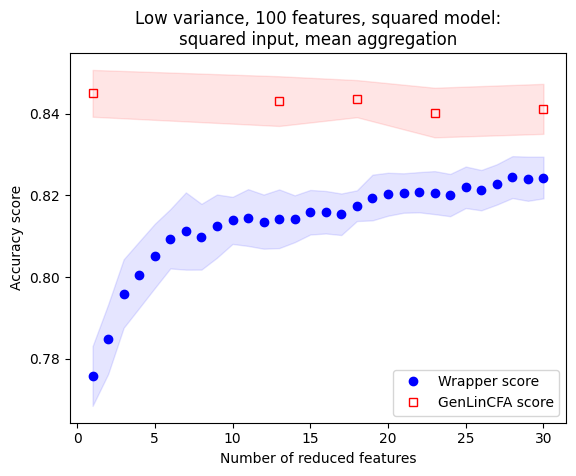

In [43]:
plot_class(results,"Low variance, 100 features, squared model:\nsquared input, mean aggregation",30,'LowVar_100Feat_quadr_class.png')


### Low noise, 100 variables, quadratic dependence (squared sums), class


In [44]:
print(f'GenLinCFA epsilon: {[results[1][0][i][0] for i in range(5)]}')


GenLinCFA epsilon: [0.77, 0.79, 0.81, 0.85, 0.95]


Wrapper:
 Mean values [0.7758, 0.7847999999999999, 0.796, 0.8006, 0.8051999999999999, 0.8094000000000001, 0.8112999999999999, 0.8099000000000001, 0.8125, 0.8139, 0.8145999999999999, 0.8136000000000001, 0.8143, 0.8143, 0.8158999999999998, 0.8158999999999998, 0.8154, 0.8175000000000001, 0.8195, 0.8202999999999999, 0.8206000000000001, 0.8208, 0.8206999999999999, 0.8201, 0.8220000000000001, 0.8213000000000001, 0.8227, 0.8244999999999999, 0.8240999999999999, 0.8244, 0.8245000000000001, 0.8251999999999999, 0.8257, 0.8248, 0.8246, 0.8241999999999999, 0.8259000000000001, 0.8253, 0.8245999999999999, 0.8251, 0.8253, 0.8253, 0.8238999999999999, 0.8249000000000001, 0.8251, 0.8251, 0.8255000000000001, 0.8255000000000001, 0.8253999999999999, 0.8234999999999999] +- [0.0073116144318474624, 0.00851551769418631, 0.008380002863961315, 0.008139075524898379, 0.007863484825444743, 0.007255707160573645, 0.009457076165496374, 0.008045316550639859, 0.007737657009715515, 0.005764199718954898, 0.0069473637014337

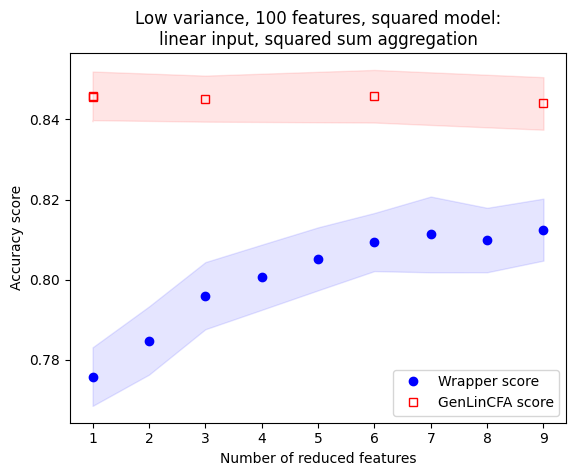

In [45]:
plot_class_squaredAggr(results,"Low variance, 100 features, squared model:\nlinear input, squared sum aggregation",9,'LowVar_100Feat_sqsum_class.png')


### High noise, 1000 variables, quadratic dependence, class

In [46]:
import pickle
with open('/Users/paolo/Documents/PaperNon_Gen_LinCFA/results/class_quadratic_retry_highVar.pkl', 'rb') as f:
    results = pickle.load(f)
print(f'GenLinCFA epsilon: {[results[0][0][i][0] for i in range(5)]}')
print(f'GenLinCFA epsilon: {[results[1][0][i][0] for i in range(5)]}')


GenLinCFA epsilon: [0.77, 0.79, 0.81, 0.83, 0.85]
GenLinCFA epsilon: [0.77, 0.79, 0.81, 0.83, 0.85]


Wrapper:
 Mean values [0.683, 0.6875, 0.6857, 0.6876, 0.6883000000000001, 0.6889000000000001, 0.6882, 0.6891999999999999, 0.6879, 0.6873, 0.6885000000000001, 0.6882999999999999, 0.6881999999999999, 0.6884, 0.6887000000000001, 0.6892999999999999, 0.6884, 0.689, 0.6889000000000001, 0.6881999999999999, 0.6887, 0.6886, 0.6895, 0.6892, 0.6887, 0.69, 0.689, 0.6885, 0.6885999999999999, 0.6883, 0.6890999999999999, 0.6896, 0.6902, 0.6889, 0.6890000000000001, 0.6893, 0.6900000000000002, 0.6895, 0.6896000000000001, 0.6893, 0.6889999999999998, 0.6889, 0.689, 0.6884, 0.688, 0.6881999999999999, 0.6881999999999999, 0.6889, 0.6894, 0.6889] +- [0.007401433374691672, 0.008120410334459685, 0.007721753272411628, 0.00871351722325719, 0.008852823368846779, 0.007668836574083428, 0.007482991487366513, 0.006928537623481574, 0.00676384612480205, 0.0068742651680015745, 0.007035553709552627, 0.007072586061689155, 0.006703085379136966, 0.006768104490919134, 0.00706715229777877, 0.006658521277280695, 0.006624684022

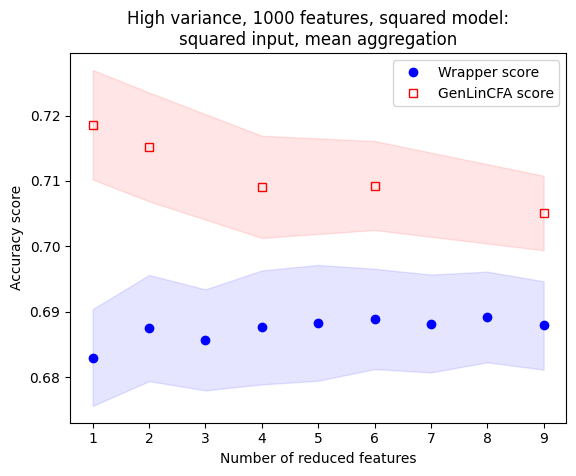

In [47]:
plot_class(results,"High variance, 1000 features, squared model:\nsquared input, mean aggregation",9,'HighVar_1000Feat_quadr_class.png')


Wrapper:
 Mean values [0.683, 0.6875, 0.6857, 0.6876, 0.6883000000000001, 0.6889000000000001, 0.6882, 0.6891999999999999, 0.6879, 0.6873, 0.6885000000000001, 0.6882999999999999, 0.6881999999999999, 0.6884, 0.6887000000000001, 0.6892999999999999, 0.6884, 0.689, 0.6889000000000001, 0.6881999999999999, 0.6887, 0.6886, 0.6895, 0.6892, 0.6887, 0.69, 0.689, 0.6885, 0.6885999999999999, 0.6883, 0.6890999999999999, 0.6896, 0.6902, 0.6889, 0.6890000000000001, 0.6893, 0.6900000000000002, 0.6895, 0.6896000000000001, 0.6893, 0.6889999999999998, 0.6889, 0.689, 0.6884, 0.688, 0.6881999999999999, 0.6881999999999999, 0.6889, 0.6894, 0.6889] +- [0.007401433374691672, 0.008120410334459685, 0.007721753272411628, 0.00871351722325719, 0.008852823368846779, 0.007668836574083428, 0.007482991487366513, 0.006928537623481574, 0.00676384612480205, 0.0068742651680015745, 0.007035553709552627, 0.007072586061689155, 0.006703085379136966, 0.006768104490919134, 0.00706715229777877, 0.006658521277280695, 0.006624684022

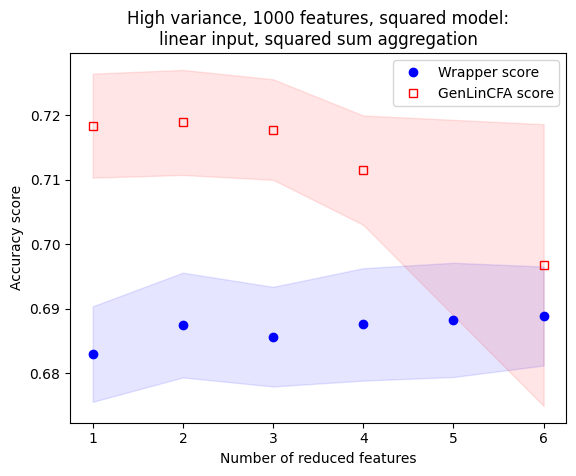

In [48]:
plot_class_squaredAggr(results,"High variance, 1000 features, squared model:\nlinear input, squared sum aggregation",6,'HighVar_1000Feat_sqsum_class.png')
